In [134]:
#Imports
from math import *
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.set_palette(palette='deep')
sns.set_color_codes(palette='deep')
mpl.rcParams.update({'font.family': 'serif', 'font.serif':'DejaVu Serif'})

%matplotlib notebook

# Load data

In [3]:
House_DataFrame = pd.read_csv('kc_house_data.csv').drop(['id','date'],axis=1)
House_DataFrame = House_DataFrame.drop(15870,axis=0) #Outlier at row 15870 confirmed to be incorrect data

# Select visualizations

This is to get some sense of what the data looks like and what features influence the price.

## Price dependence on location

Location is typically considered a strong predictor of house price. Let's see what locations tend to be more or less expensive.

In [4]:
latitude = House_DataFrame['lat'].values
longitude = House_DataFrame['long'].values
price = House_DataFrame['price'].values

In [5]:
#Histogram of latitude and longitude
NumBins = 30
denominator, xedges, yedges = np.histogram2d(longitude,latitude,bins=NumBins)
numerator, _, _ = np.histogram2d(longitude,latitude,bins=[xedges, yedges], weights=price)
Histogram = numerator/denominator
Histogram[Histogram==0] = np.nan
HistogramMasked = np.ma.masked_invalid(Histogram)

<IPython.core.display.Javascript object>


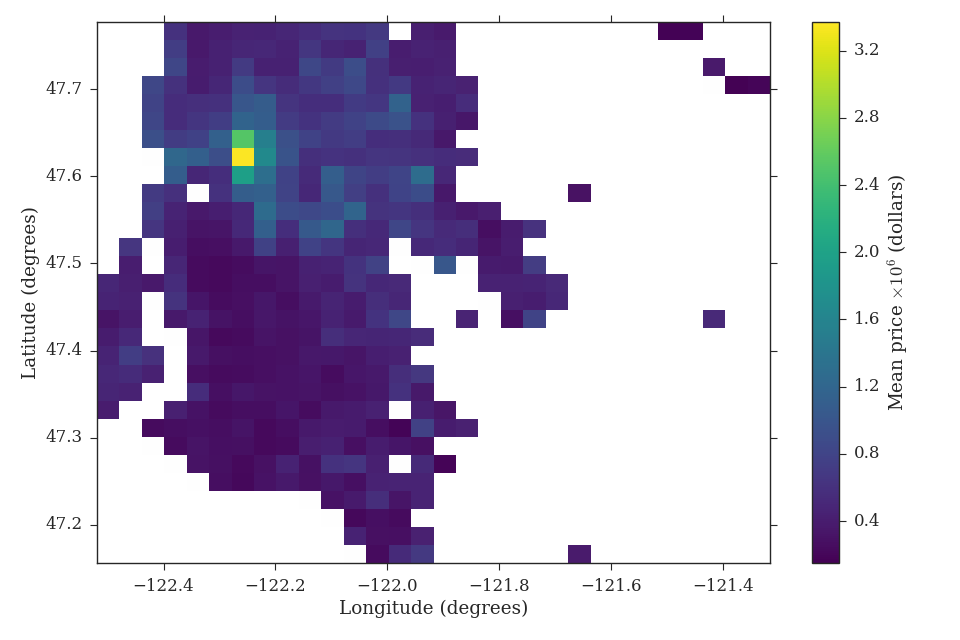

In [20]:
#Plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
#im = ax.pcolormesh(xedges,yedges,HistogramMasked.T*10**-6, cmap='viridis')
im = ax.imshow(np.fliplr(HistogramMasked*10**-6).T, extent=extent, interpolation='None',cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Mean price $\\times 10^6$ (dollars)')
ax.set_aspect('auto')
ax.set_xlim(xedges[0],xedges[-1])
ax.set_ylim(yedges[0],yedges[-1])
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
plt.tight_layout()

There seems to be a region of expensive homes near (-122.25, 47.6) with a gradual drop off further from this region. Perhaps K-nearest neighbors would be a good model for predicting prices based on location.

## Square footage

House size (i.e. square footage) is also considered a strong price predictor. This data set has multiple features associated with square footage. The features labeleled with '15' correspond with the average square footage of the 15 nearest homes rather than the home itself.

<IPython.core.display.Javascript object>


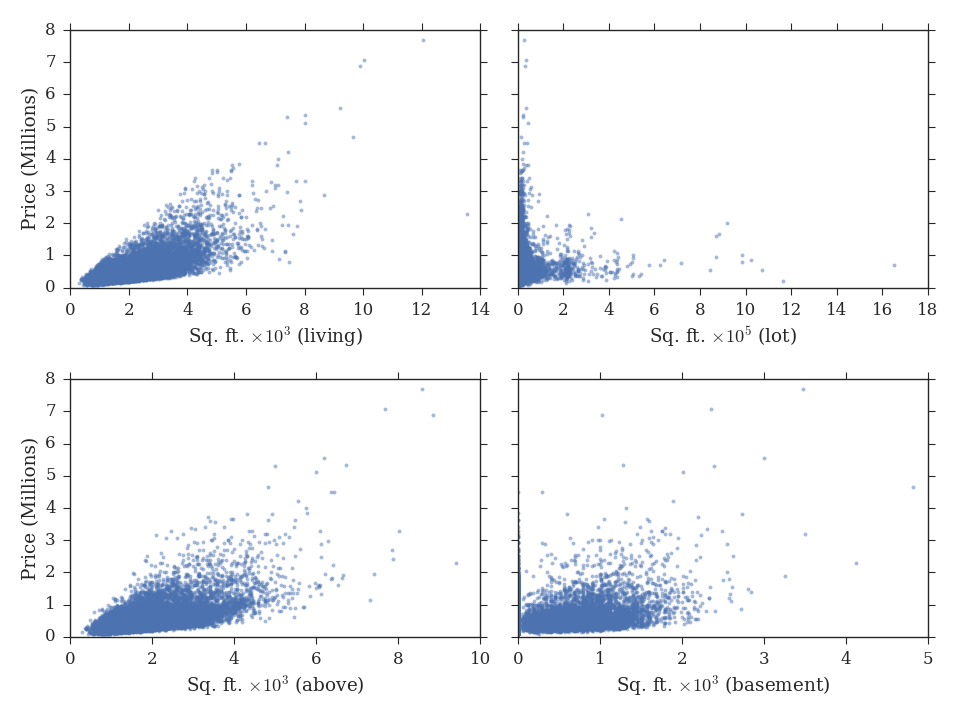

In [21]:
fig,ax = plt.subplots(2,2,sharey=True,figsize=(12, 9))

opacity = 0.5

ax[0,0].plot(House_DataFrame['sqft_living'].values/10**3,price/10**6,marker='.',linestyle='None',alpha=opacity)
ax[0,0].set_xlabel('Sq. ft. $\\times 10^3$ (living)')
ax[0,0].set_ylabel('Price (Millions)')
ax[0,1].plot(House_DataFrame['sqft_lot'].values/10**5,price/10**6,marker='.',linestyle='None',alpha=opacity)
ax[0,1].set_xlabel('Sq. ft. $\\times 10^5$ (lot)') #Whatever 15 means...
ax[1,0].plot(House_DataFrame['sqft_above'].values/10**3,price/10**6,marker='.',linestyle='None',alpha=opacity)
ax[1,0].set_xlabel('Sq. ft. $\\times 10^3$ (above)')
ax[1,0].set_ylabel('Price (Millions)')
ax[1,1].plot(House_DataFrame['sqft_basement'].values/10**3,price/10**6,marker='.',linestyle='None',alpha=opacity)
ax[1,1].set_xlabel('Sq. ft. $\\times 10^3$ (basement)')
plt.tight_layout()

There appears to be a strong linear relationship between the square footage of living space and price. For basement square footage, there are a lot of data points with a value of zero, presumably indicating they have no basement.

## Grade and condition

The features 'grade' and 'condition' presumably relate to the condition of the house and would be expected to strongly influence price.

<IPython.core.display.Javascript object>


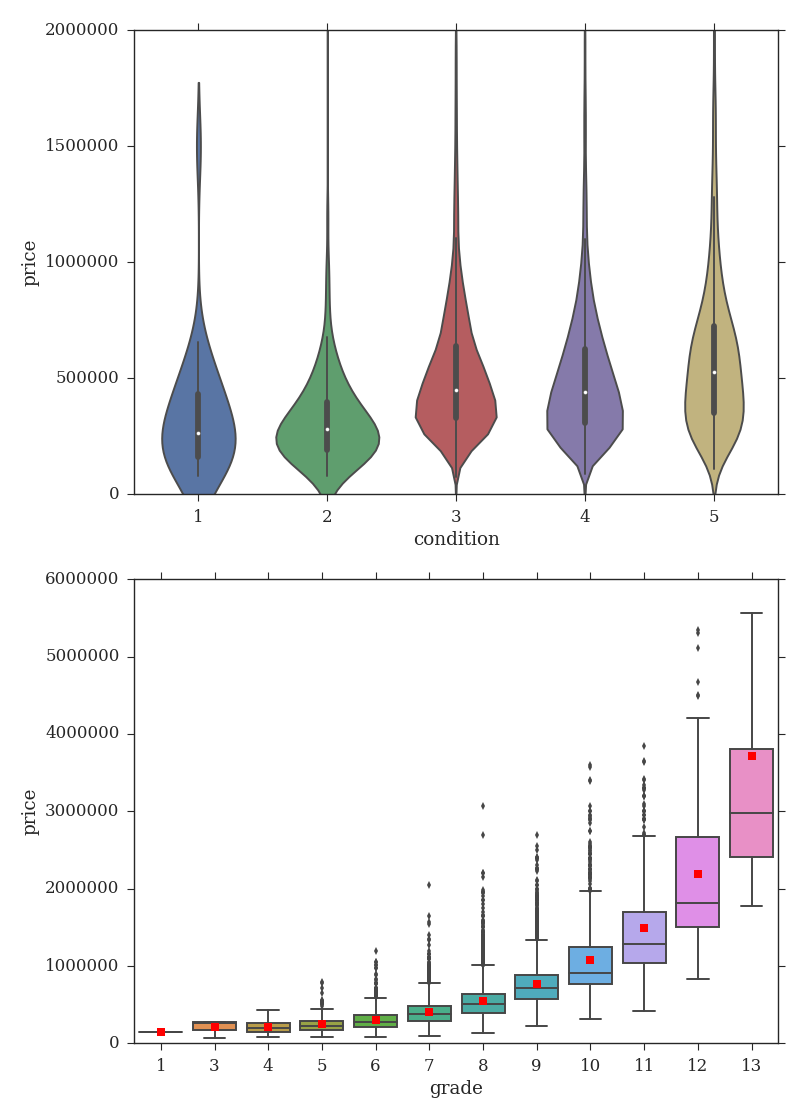

In [22]:
fig,ax = plt.subplots(2,figsize=(10, 14))

#Condition
sns.violinplot(x='condition', y='price', data=House_DataFrame, orient='v', showmeans=True, ax=ax[0])
ax[0].set_ylim(0,2*10**6)

#Grade
sns.boxplot(x='grade', y='price', data=House_DataFrame, orient='v', showmeans=True, ax=ax[1])
ax[1].set_ylim(0,6*10**6)

plt.tight_layout()

In [62]:
r_condition_price = sp.stats.pearsonr(House_DataFrame['condition'].values, House_DataFrame['price'].values)[0]
r_grade_price = sp.stats.pearsonr(House_DataFrame['grade'].values, House_DataFrame['price'].values)[0]
print(r_condition_price,r_grade_price)

0.0363360942064 0.667447259299


The 'condition' seems to be a much worse predictor than expected with almost no correlation. 'Grade', however, appears to be a good predictor.

## Number of bedrooms and bathrooms

Next, let's look at the price dependence on the number of bedrooms and bathrooms.

In [69]:
np.arange(0, 30, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])

In [119]:
ax[1].get_xticks() 

array([ -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,
         8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,
        17.5,  18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,
        26.5,  27.5,  28.5])

<IPython.core.display.Javascript object>


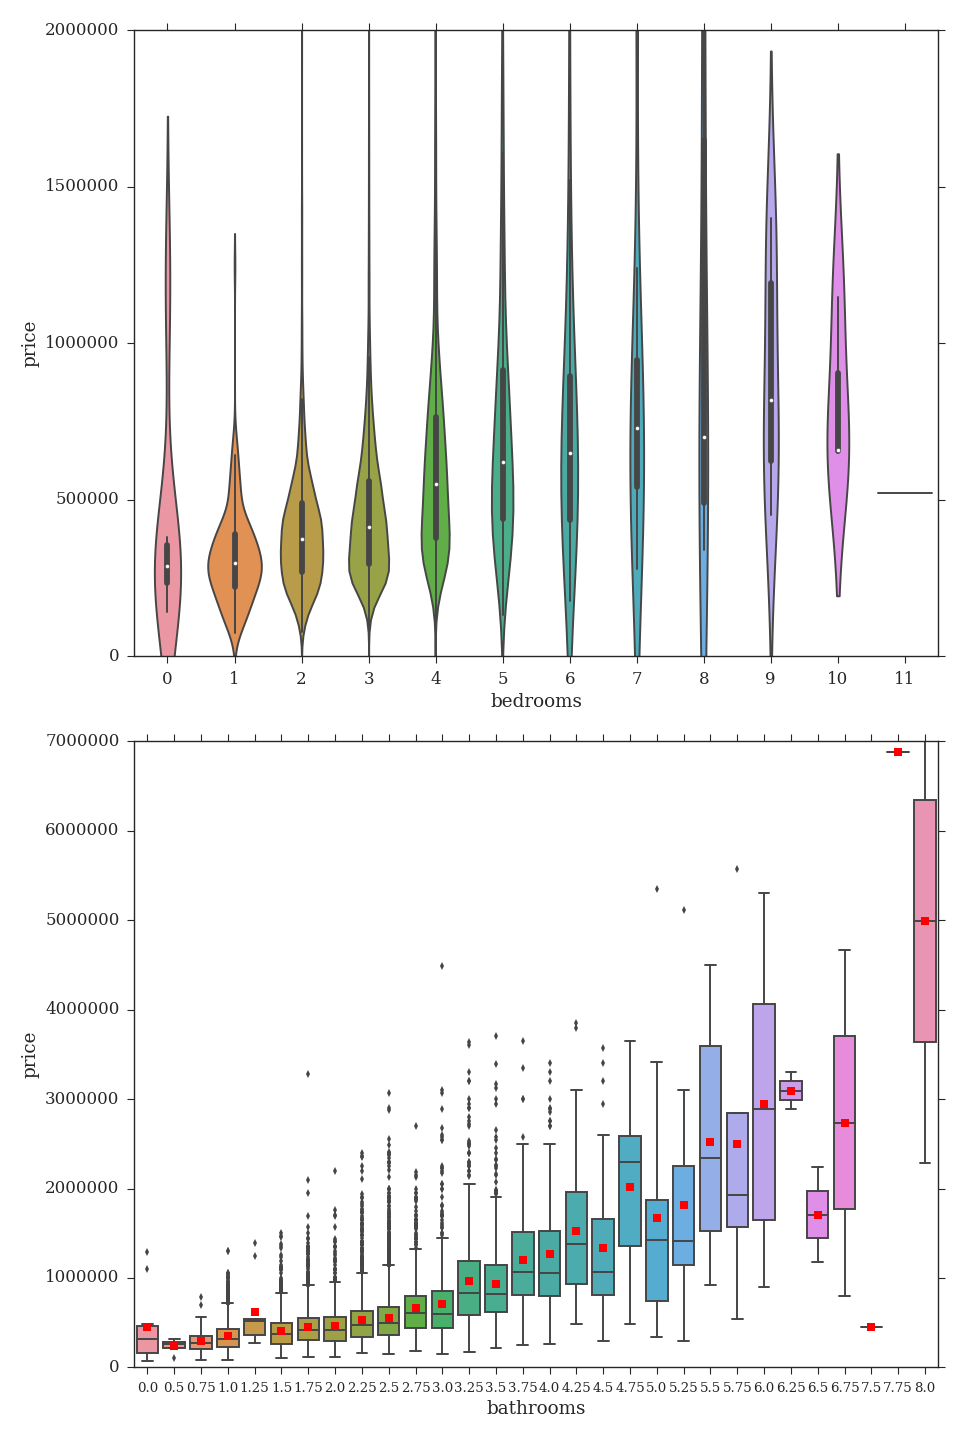

In [124]:
fig,ax = plt.subplots(2,figsize=(12, 18))

#Bedrooms
sns.violinplot(x='bedrooms', y='price', data=House_DataFrame, orient='v', showmeans=True, ax=ax[0])
ax[0].set_ylim(0,2*10**6)

#Bathrooms
sns.boxplot(x='bathrooms', y='price', data=House_DataFrame, orient='v', showmeans=True, ax=ax[1])
ax[1].set_ylim(0,7*10**6)
ax[1].tick_params(axis='x',labelsize=12)

plt.tight_layout()

In [61]:
r_bed_price = sp.stats.pearsonr(House_DataFrame['bedrooms'].values, House_DataFrame['price'].values)[0]
r_bath_price = sp.stats.pearsonr(House_DataFrame['bathrooms'].values, House_DataFrame['price'].values)[0]
print(r_bed_price,r_bath_price)

0.315444864864 0.525147094736


The number of bedrooms doesn't appear to be as a good predictor as the number of bathrooms. It's worth keeping in mind that a house with many bedrooms/bathrooms would also likely have a large square footage. Let's take a quick look at this.

<IPython.core.display.Javascript object>


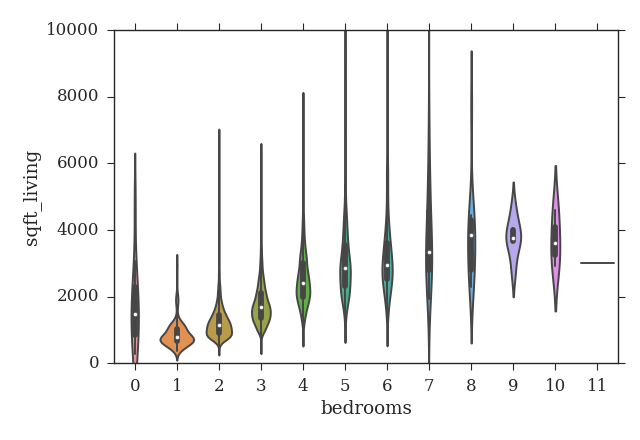

In [153]:
plt.figure()
sns.violinplot(x='bedrooms',y='sqft_living', data=House_DataFrame, orient='v', showmeans=True)
plt.ylim(0,10000)
plt.tight_layout()

In [59]:
r = sp.stats.pearsonr(House_DataFrame['sqft_living'].values, House_DataFrame['bedrooms'].values)[0]
print(r)

0.591467222122


There is a modest correlation. This could be convoluting the true relationship between the price and the number of bathrooms. 

## Scatterplots of all pairs of features (slow)

Lastly, let's look at the correlation between all pairs of features using seaborn's pairplot function.

<IPython.core.display.Javascript object>


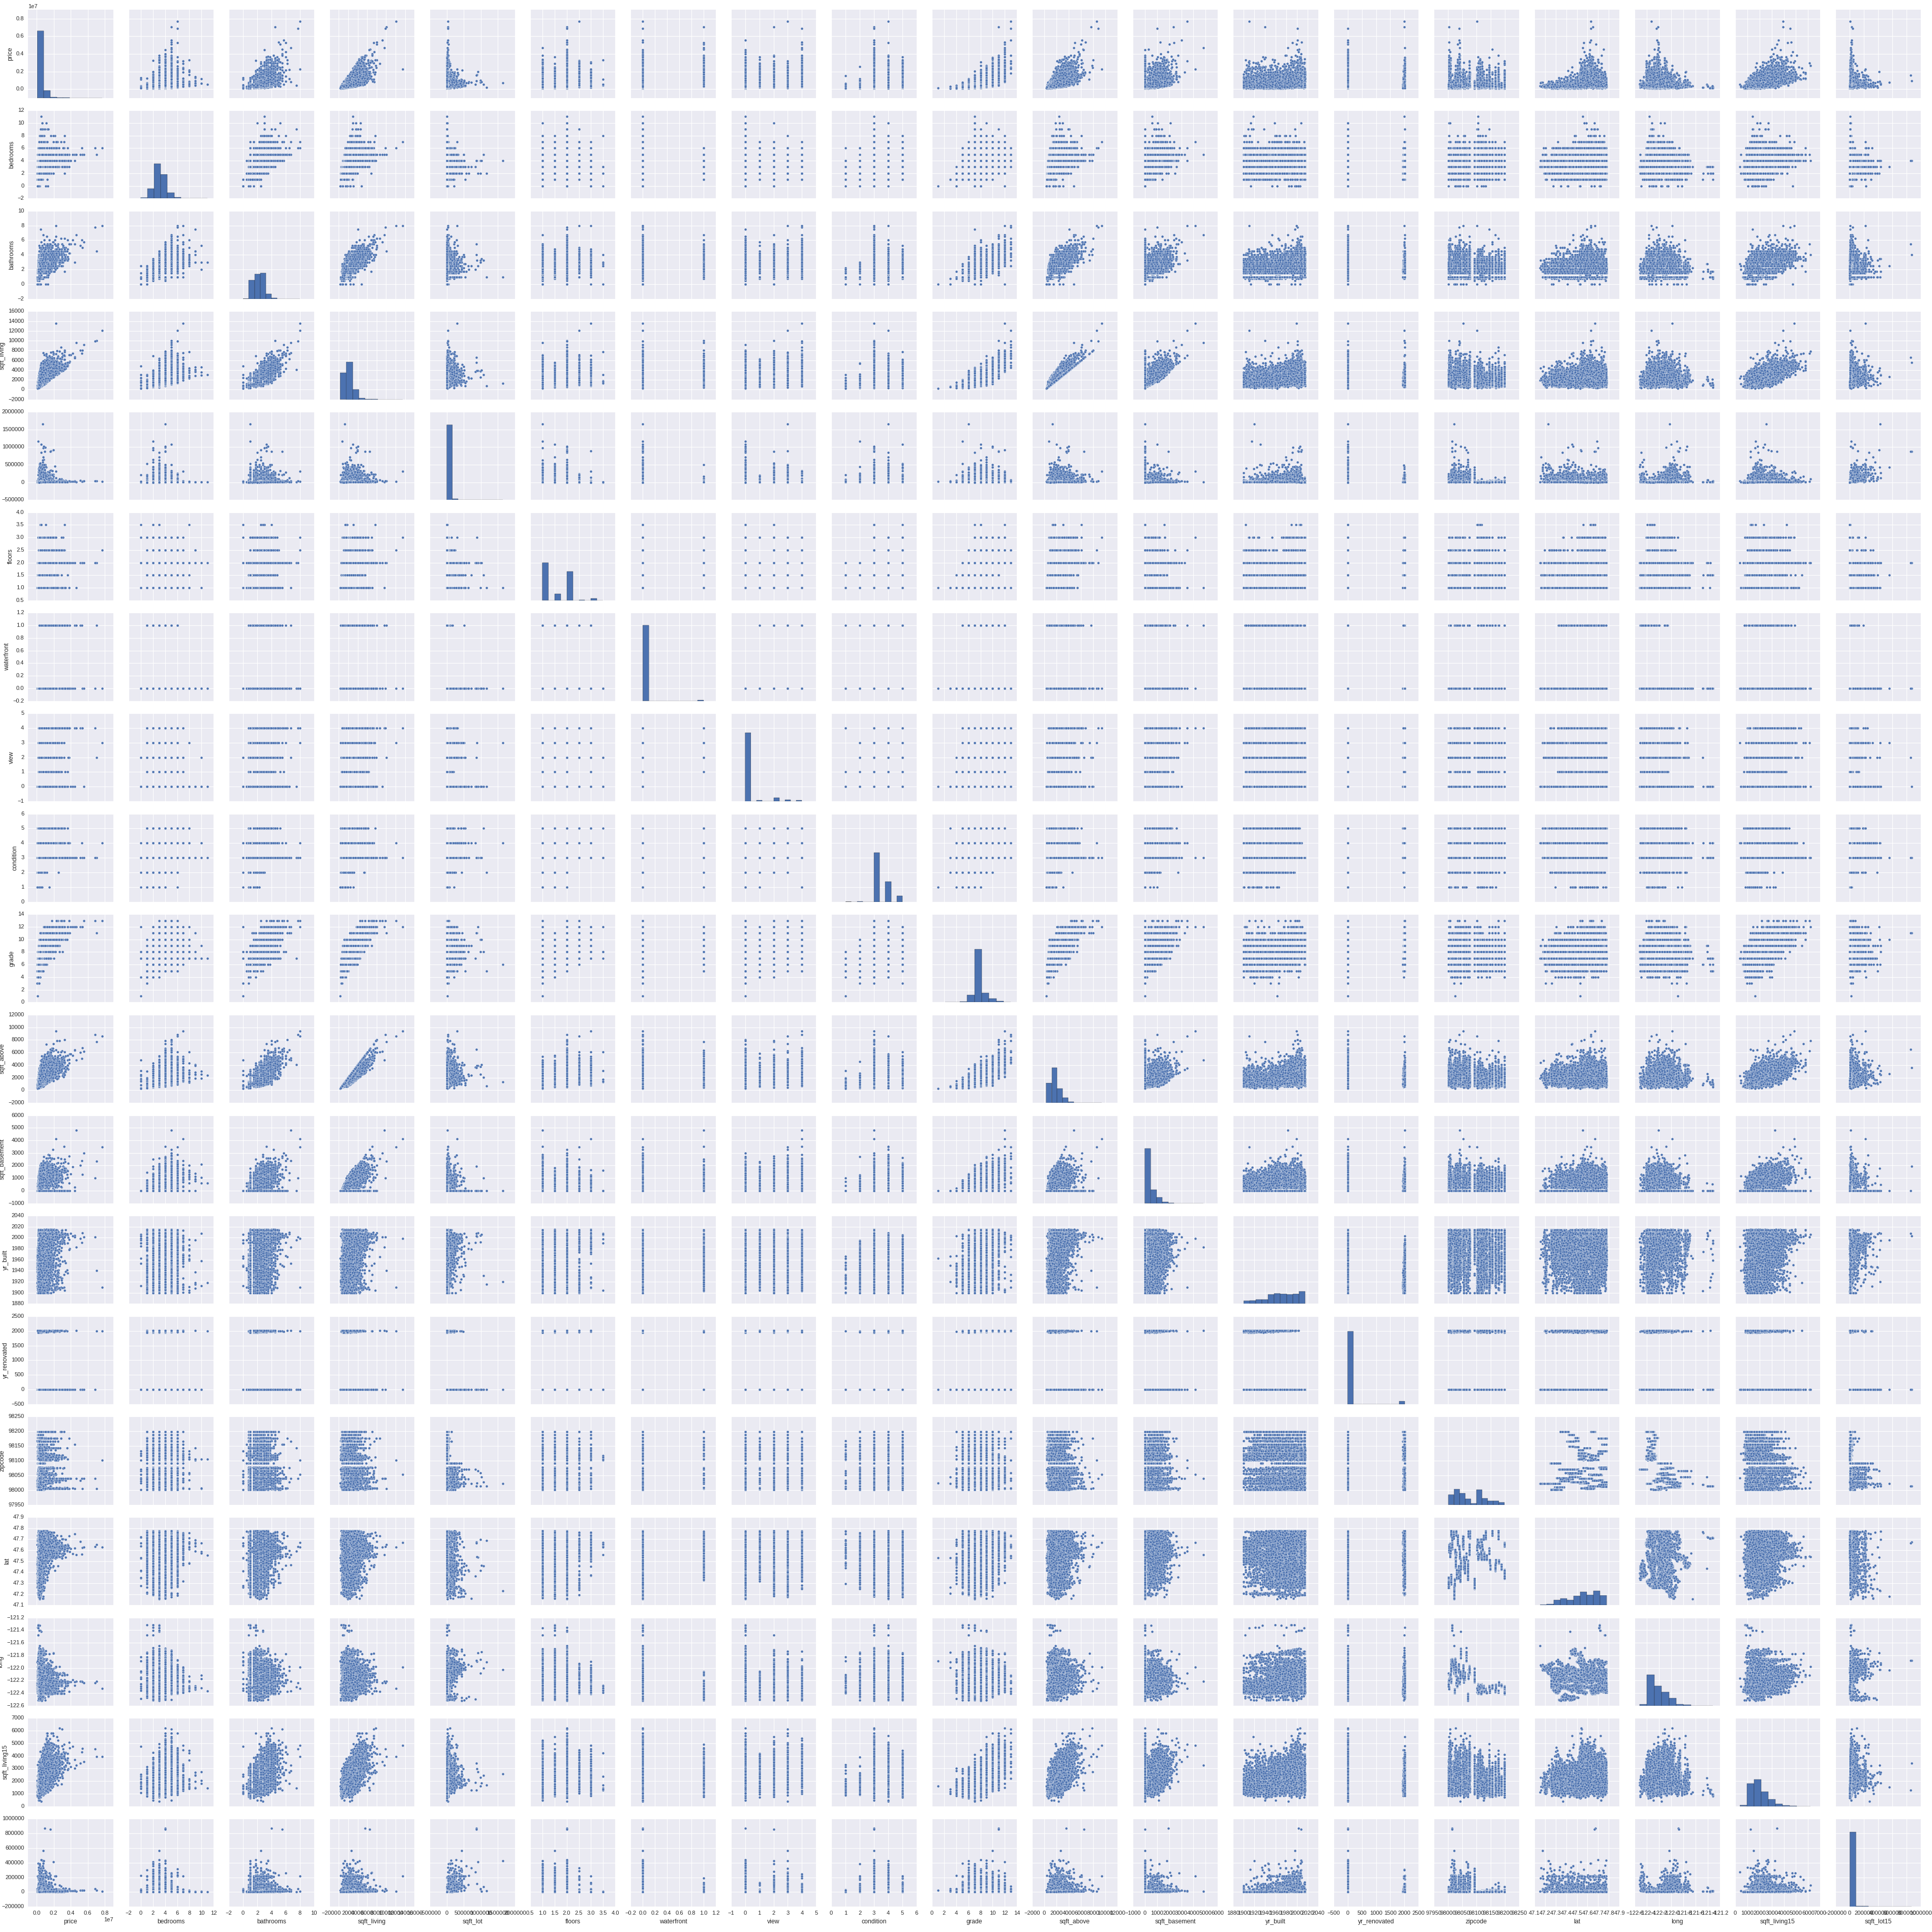

In [64]:
sns.set(font_scale=1.0)
sns.pairplot(House_DataFrame)

# Regression

## Split data into training and testing sets

In [126]:
#data = House_DataFrame.drop(['id','price','id','date'],axis=1).values
#data = House_DataFrame['condition'].values #Select a single feature
data = House_DataFrame[['sqft_living','sqft_above']].values #Select two features
target = House_DataFrame['price'].values

In [127]:
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size=0.7, random_state=123)
print("Labels for training and testing data")
print(train_target)
print(test_target)

Labels for training and testing data
[ 589000.  646000.  299000. ...,  425000.  640000.  500000.]
[ 150000.  279000.  435000. ...,  285950.  364000.  465000.]


## Ordinary least squares

In [128]:
linreg = LinearRegression()

In [129]:
linreg.fit(train_data, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
print('Weight coefficients: ', linreg.coef_)
print('y-axis intercept: ', linreg.intercept_)

Weight coefficients:  [ 297.54103263  -18.8006552 ]
y-axis intercept:  -43353.5313466


In [149]:
lin_train = linreg.predict(train_data)
lin_test = linreg.predict(test_data)
print('R^2 =',linreg.score(test_data, test_target))
print('RMSE =',np.sqrt(sklearn.metrics.mean_squared_error(test_target,lin_test)))

R^2 = 0.506088452815
RMSE = 248406.668448


<IPython.core.display.Javascript object>


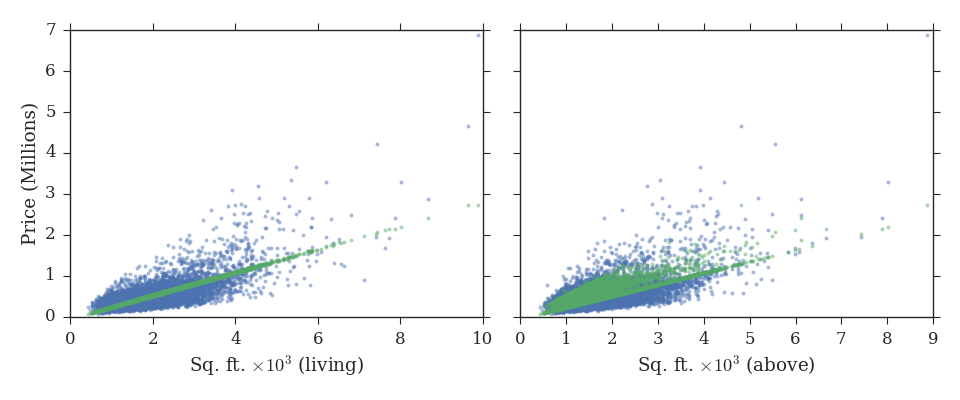

In [133]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(12, 5))
opacity = 0.5
ax[0].plot(test_data[:,0]/10**3,test_target/10**6,marker='.',linestyle='None', alpha=opacity)
ax[0].plot(test_data[:,0]/10**3,lin_test/10**6,marker='.',linestyle='None', alpha=opacity)
ax[0].set_xlabel('Sq. ft. $\\times 10^3$ (living)')
ax[0].set_ylabel('Price (Millions)')
ax[1].plot(test_data[:,1]/10**3,test_target/10**6,marker='.',linestyle='None', alpha=opacity)
ax[1].plot(test_data[:,1]/10**3,lin_test/10**6,marker='.',linestyle='None', alpha=opacity)
ax[1].set_xlabel('Sq. ft. $\\times 10^3$ (above)') #Whatever 15 means...
plt.tight_layout()

## K-nearest neighbors

In [171]:
Num_n_neighbors = 20
n_neighbors = np.arange(1,Num_n_neighbors+1)

knn_R2 = np.zeros(Num_n_neighbors)
knn_RMSE = np.zeros(Num_n_neighbors)

for idx,n in enumerate(n_neighbors):
    
    knnreg = KNeighborsRegressor(n_neighbors=n)
    
    knnreg.fit(train_data, train_target)
    
    knn_train = knnreg.predict(train_data)
    knn_test = knnreg.predict(test_data)
    
    knn_R2[idx] = knnreg.score(test_data, test_target)
    knn_RMSE[idx] = np.sqrt(sklearn.metrics.mean_squared_error(test_target,knn_test))

<IPython.core.display.Javascript object>


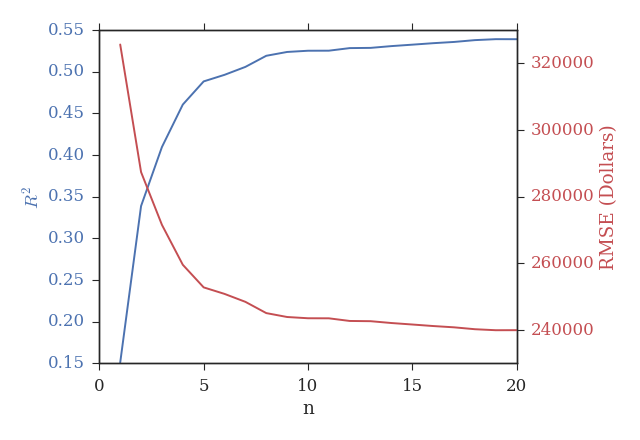

In [172]:
fig, ax1 = plt.subplots(figsize=(8,5.5))

#Plot R^2 on the left axis
ax1.plot(n_neighbors, knn_R2, color='b')
ax1.set_xlabel('n')
ax1.set_ylabel('$R^2$', color="b")
for label in ax1.get_yticklabels():
    label.set_color("b")

#Plot RMSE on the right axis
ax2 = ax1.twinx() 
ax2.plot(n_neighbors, knn_RMSE, color='r')
ax2.set_ylabel('RMSE (Dollars)', color="r")
for label in ax2.get_yticklabels():
    label.set_color("r")

plt.tight_layout()